In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot create regular file '/root/kaggle/': Not a directory
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [21]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [22]:
! kaggle datasets download adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal

100% 604M/605M [00:35<00:00, 19.1MB/s]
100% 605M/605M [00:35<00:00, 17.9MB/s]


In [23]:
! unzip /content/air-pollution-image-dataset-from-india-and-nepal.zip

Streaming output truncated to the last 5000 lines.
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-1.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-106.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-113.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-120.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-127.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise

In [24]:
import sys

from typing import Dict, Optional, Tuple
from pathlib import Path

import math

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend #Keras version 2.1.6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LeakyReLU, Input, Conv2D, MaxPooling2D 

from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
#from PIL import Image

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

%matplotlib inline

In [25]:
import pandas as pd
df = pd.read_csv('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [26]:
df = shuffle(df)

df.sample(frac=1).reset_index(drop=True)

number_of_rows = 3000
sub_dfs = [df[i:i + number_of_rows] for i in range(0, df.shape[0], number_of_rows)]
for idx, sub_df in enumerate(sub_dfs):
    sub_df.to_csv(f'frag3000_{idx}.csv', index=False)

In [27]:
df = pd.read_csv('/content/frag3000_1.csv')
df.head(15)

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Knowledge park, Greater Noida",UP_SEV_2023-02-20-08.30-1-40.jpg,2023,2,20,8:30,331,356.00,248.00,2.00,109.00,11.00,83.00,f_Severe
1,Bengaluru,BENGR_Mod_2023-02-25-08.30-1-621.jpg,2023,2,25,8:30,73,29.00,64.00,23.00,189.00,7.00,16.00,b_Moderate
2,"Biratnagar, Nepal",BIR_UNFSG_VF_2023-02-03-16.00-2-108.jpg,2023,2,3,16:00,141,50.29,72.18,59.66,0.45,2.60,4.19,c_Unhealthy_for_Sensitive_Groups
3,Tamil Nadu,TN_UnFSG_2023-03-03-09.00-2-276.jpg,2023,3,3,9:00,121,70.00,113.00,21.00,409.00,20.00,18.00,c_Unhealthy_for_Sensitive_Groups
4,"Biratnagar, Nepal",BIR_UNFSG_VF_2023-02-03-16.00-1-50.jpg,2023,2,3,16:00,141,50.29,72.18,59.66,0.45,2.60,4.19,c_Unhealthy_for_Sensitive_Groups
5,Mumbai,MH_UnFSG_2023-03-08-11.00-1-111.jpg,2023,3,8,11:00,124,287.00,177.00,NaN,NaN,NaN,85.00,c_Unhealthy_for_Sensitive_Groups
6,"Biratnagar, Nepal",BIR_UH_2023-03-16-12.30-3-274.jpg,2023,3,16,12:30,154,65.89,95.23,78.31,0.36,3.50,1.03,d_Unhealthy
7,Mumbai,MH_UN_2023-03-02-08.00-1-71.jpg,2023,3,2,8:00,156,305.00,193.00,8.00,100.00,NaN,119.00,d_Unhealthy
8,"ITO, Delhi",DEL_UnH_2023-02-15-11.30-2-5.jpg,2023,2,15,11:30,179,287.00,180.00,42.00,52.00,20.00,66.00,d_Unhealthy
9,"Dimapur, Nagaland",Dimapur_UHFSG_2023-02-02- 09.00-1.jpg,2023,2,2,9:00,103,53.00,84.00,13.00,2.00,3.00,5.00,c_Unhealthy_for_Sensitive_Groups


In [28]:
import numpy as np
def build_x(path):
    train_img = []
    for i in range(df.shape[0]):
        img = image.load_img(path + df['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x

In [29]:
x_origin = build_x('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

In [30]:
x_origin.shape

(3000, 224, 224, 3)

In [32]:
pm25 =pd.DataFrame(df['PM2.5'])
pm25

,PM2.5
0,356.00
1,29.00
2,50.29
3,70.00
4,50.29
...,...
2995,185.00
2996,26.00
2997,22.00
2998,50.29


In [33]:
x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_origin, pm25, train_size=0.8, shuffle=True)

In [34]:
x_origin_valid, x_origin_test, y_valid, y_test = train_test_split(x_origin_temp, y_temp, test_size=0.5, shuffle=True)

In [35]:
x_origin_train.shape

(2400, 224, 224, 3)

In [36]:
y_train.shape

(2400, 1)

In [37]:
x_origin = []
x_origin_temp = []
y_temp = []
y = []

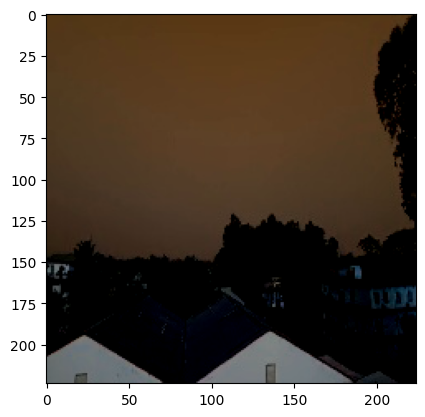

In [38]:
plt.imshow(x_origin_test[10]/255)

In [82]:
y_coba = y_train.to_numpy().tolist()

In [83]:
y_coba[0] > 1

TypeError: ignored

In [85]:
#Classify the Ground Truth PM25 concentration to the air quality levels

y_train_pm25 = np.zeros(len(y_coba))

for i in range(len(y_coba)):
    if int(y_coba[i][0])  <= 12.0:
        y_train_pm25[i] = 0
    elif int(y_coba[i][0]) <= 35.4:
        y_train_pm25[i] = 1
    elif int(y_coba[i][0]) <= 55.4:
        y_train_pm25[i] = 2
    elif int(y_coba[i][0]) <= 150.4:
        y_train_pm25[i] = 3
    elif int(y_coba[i][0]) <= 250.4:
        y_train_pm25[i] = 4
    elif int(y_coba[i][0]) > 250.5:
        y_train_pm25[i] = 5
    else:
        print('Exception Occured!')

y_train_pm25 = y_train_pm25.astype(int)
        
        
y_train_pm25


array([4, 3, 4, ..., 3, 4, 2])

In [86]:
#import Counter
from collections import Counter

#input list
input_list = y_train_pm25

#keys of the dictionary will be the unique items 
print(Counter(input_list).keys())

#values will be the number of that key present in the list
print(Counter(input_list).values())

#new list with key-value pairs
print(Counter(input_list))

#count of unique values
print("Count- ", len(Counter(input_list)))

dict_keys([4, 3, 1, 5, 2, 0])
dict_values([234, 554, 656, 660, 278, 18])
Counter({5: 660, 1: 656, 3: 554, 2: 278, 4: 234, 0: 18})
Count-  6


In [39]:
y_test = y_test.reset_index(drop=True)
y_test

,PM2.5
0,102.00
1,65.89
2,301.00
3,29.00
4,185.00
...,...
295,287.00
296,268.00
297,70.08
298,47.96


In [40]:
y_test.head(15)

,PM2.5
0,102.00
1,65.89
2,301.00
3,29.00
4,185.00
5,20.00
6,68.92
7,22.00
8,257.00
9,37.00


In [41]:
pre_trained_model  = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False
    print(layer.name)

58889256/58889256 [==============================] - 4s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [42]:
x1 = Flatten()(pre_trained_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='linear')(fc2)
model = Model(pre_trained_model.input, x)
    
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=opt)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
weight_path="{}_aqi.best.hdf5".format('vgg16')

In [44]:
callback = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto'),
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                    save_best_only=True, mode='min', save_weights_only = True)]
history = model.fit(x=x_origin_train, y=y_train, validation_data=(x_origin_valid, y_valid), batch_size=16, epochs=150, callbacks=callback)

Epoch 1/150
150/150 [==============================] - ETA: 0s - loss: 6425.6963
Epoch 1: val_loss improved from inf to 3412.05200, saving model to vgg16_aqi.best.hdf5
150/150 [==============================] - 25s 89ms/step - loss: 6425.6963 - val_loss: 3412.0520
Epoch 2/150
150/150 [==============================] - ETA: 0s - loss: 2237.2454
Epoch 2: val_loss improved from 3412.05200 to 2177.31421, saving model to vgg16_aqi.best.hdf5
150/150 [==============================] - 11s 75ms/step - loss: 2237.2454 - val_loss: 2177.3142
Epoch 3/150
150/150 [==============================] - ETA: 0s - loss: 1401.3113
Epoch 3: val_loss did not improve from 2177.31421
150/150 [==============================] - 11s 75ms/step - loss: 1401.3113 - val_loss: 2198.0906
Epoch 4/150
150/150 [==============================] - ETA: 0s - loss: 934.0072
Epoch 4: val_loss improved from 2177.31421 to 1929.62622, saving model to vgg16_aqi.best.hdf5
150/150 [==============================] - 12s 78ms/step - lo

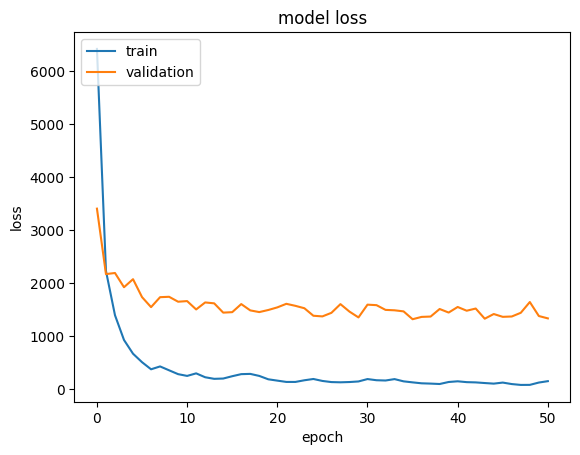

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
model.load_weights(weight_path)

In [47]:
loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is :', loss ** 0.5)

19/19 [==============================] - 1s 67ms/step - loss: 1093.5397
RMSE is : 33.068711387829474


In [48]:
y_predict = model.predict(x_origin_test)

10/10 [==============================] - 6s 111ms/step


In [49]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predict)

0.9269864118519289

In [51]:
y_predict_pm25 = np.zeros(len(y_predict))

for i in range(len(y_predict)):
    if y_predict[i] <= 12.0:
        y_predict_pm25[i] = 0
    elif y_predict[i] <= 35.4:
        y_predict_pm25[i] = 1
    elif y_predict[i] <= 55.4:
        y_predict_pm25[i] = 2
    elif y_predict[i] <= 150.4:
        y_predict_pm25[i] = 3
    elif y_predict[i] <= 250.4:
        y_predict_pm25[i] = 4
    elif y_predict[i] > 250.4 :
        y_predict_pm25[i] = 5
    else:
        print('Exception Occured!')
    
y_predict_pm25 = y_predict_pm25.astype(int)
    
    
y_predict_pm25

array([3, 3, 5, 2, 4, 1, 3, 3, 4, 1, 3, 4, 5, 1, 3, 1, 5, 1, 2, 4, 1, 3,
       3, 4, 1, 3, 2, 3, 3, 3, 1, 3, 3, 3, 5, 3, 5, 4, 2, 5, 5, 4, 4, 1,
       1, 3, 1, 3, 5, 5, 3, 1, 2, 1, 3, 2, 2, 2, 3, 2, 1, 1, 1, 4, 5, 5,
       5, 2, 4, 2, 3, 1, 3, 4, 1, 3, 2, 3, 3, 4, 4, 5, 4, 3, 2, 1, 2, 3,
       1, 2, 4, 3, 5, 3, 5, 3, 5, 3, 3, 3, 1, 3, 3, 2, 1, 1, 3, 4, 5, 3,
       3, 5, 1, 1, 4, 3, 4, 5, 0, 2, 3, 5, 3, 3, 1, 3, 5, 5, 5, 5, 1, 4,
       1, 1, 3, 3, 1, 1, 3, 3, 5, 3, 3, 3, 3, 4, 4, 1, 5, 3, 2, 4, 2, 5,
       5, 4, 1, 3, 1, 4, 3, 5, 5, 1, 3, 3, 3, 3, 4, 5, 5, 5, 1, 4, 4, 3,
       5, 4, 1, 3, 1, 3, 2, 1, 4, 5, 3, 5, 5, 3, 5, 3, 1, 3, 5, 1, 4, 5,
       3, 4, 4, 2, 5, 3, 3, 3, 5, 1, 1, 1, 5, 5, 3, 3, 1, 3, 1, 3, 5, 1,
       3, 3, 5, 4, 1, 1, 3, 5, 3, 3, 4, 4, 5, 4, 4, 1, 3, 1, 3, 4, 2, 3,
       5, 3, 5, 2, 1, 3, 1, 3, 2, 5, 5, 1, 5, 1, 3, 3, 4, 5, 3, 1, 5, 5,
       2, 1, 2, 4, 3, 1, 2, 3, 4, 2, 4, 5, 3, 1, 5, 5, 3, 5, 2, 1, 3, 1,
       5, 2, 5, 5, 3, 2, 2, 5, 3, 5, 5, 3, 3, 3])

In [52]:
y_test = y_test.to_numpy().tolist()
y_test

[[102.0],
 [65.89],
 [301.0],
 [29.0],
 [185.0],
 [20.0],
 [68.92],
 [22.0],
 [257.0],
 [37.0],
 [53.0],
 [185.0],
 [287.0],
 [22.0],
 [65.89],
 [27.0],
 [348.0],
 [35.0],
 [34.0],
 [190.0],
 [14.0],
 [34.0],
 [31.0],
 [185.0],
 [24.0],
 [32.0],
 [29.0],
 [70.0],
 [65.89],
 [67.06],
 [27.0],
 [53.0],
 [102.0],
 [72.0],
 [348.0],
 [308.0],
 [337.0],
 [174.0],
 [55.0],
 [409.0],
 [337.0],
 [180.0],
 [84.0],
 [21.0],
 [27.0],
 [65.89],
 [18.0],
 [174.0],
 [401.0],
 [257.0],
 [66.2],
 [47.96],
 [50.29],
 [21.0],
 [100.0],
 [50.29],
 [50.29],
 [35.0],
 [31.0],
 [32.0],
 [32.0],
 [26.0],
 [43.0],
 [132.0],
 [337.0],
 [370.0],
 [277.0],
 [54.0],
 [217.0],
 [50.29],
 [39.0],
 [27.0],
 [65.89],
 [257.0],
 [27.0],
 [53.0],
 [55.0],
 [114.0],
 [111.0],
 [102.0],
 [185.0],
 [343.0],
 [193.0],
 [70.0],
 [49.0],
 [43.0],
 [32.0],
 [19.0],
 [47.0],
 [53.0],
 [193.0],
 [84.0],
 [337.0],
 [63.33],
 [337.0],
 [54.0],
 [334.0],
 [111.0],
 [63.33],
 [32.0],
 [37.0],
 [114.0],
 [65.89],
 [50.29],
 [27.0],


In [53]:
y_test[1][0]

65.89

In [55]:
#Classify the Ground Truth PM25 concentration to the air quality levels

y_test_pm25 = np.zeros(len(y_test))

for i in range(len(y_test)):
    if int(y_test[i][0])  <= 12.0:
        y_test_pm25[i] = 0
    elif int(y_test[i][0]) <= 35.4:
        y_test_pm25[i] = 1
    elif int(y_test[i][0]) <= 55.4:
        y_test_pm25[i] = 2
    elif int(y_test[i][0]) <= 150.4:
        y_test_pm25[i] = 3
    elif int(y_test[i][0]) <= 250.4:
        y_test_pm25[i] = 4
    elif int(y_test[i][0]) > 250.5:
        y_test_pm25[i] = 5
    else:
        print('Exception Occured!')

y_test_pm25 = y_test_pm25.astype(int)
        
        
y_test_pm25

array([3, 3, 5, 1, 4, 1, 3, 1, 5, 2, 2, 4, 5, 1, 3, 1, 5, 1, 1, 4, 1, 1,
       1, 4, 1, 1, 1, 3, 3, 3, 1, 2, 3, 3, 5, 5, 5, 4, 2, 5, 5, 4, 3, 1,
       1, 3, 1, 4, 5, 5, 3, 2, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 2, 3, 5, 5,
       5, 2, 4, 2, 2, 1, 3, 5, 1, 2, 2, 3, 3, 3, 4, 5, 4, 3, 2, 2, 1, 1,
       2, 2, 4, 3, 5, 3, 5, 2, 5, 3, 3, 1, 2, 3, 3, 2, 1, 1, 3, 4, 5, 3,
       3, 5, 1, 1, 5, 3, 4, 5, 0, 2, 3, 5, 3, 3, 1, 3, 5, 5, 5, 5, 1, 5,
       1, 1, 3, 3, 1, 1, 1, 3, 5, 3, 3, 3, 3, 3, 4, 1, 5, 3, 2, 4, 2, 5,
       5, 1, 1, 3, 1, 5, 1, 5, 5, 1, 3, 3, 3, 2, 4, 5, 5, 5, 1, 4, 4, 3,
       5, 4, 1, 3, 1, 3, 2, 1, 4, 5, 3, 5, 5, 3, 5, 3, 1, 3, 5, 1, 4, 5,
       3, 4, 4, 1, 5, 3, 2, 3, 5, 0, 1, 1, 5, 5, 3, 3, 1, 3, 1, 3, 5, 1,
       1, 3, 5, 4, 1, 1, 3, 5, 1, 3, 4, 5, 5, 4, 3, 1, 2, 1, 3, 4, 2, 3,
       5, 3, 5, 2, 1, 3, 1, 3, 2, 5, 5, 0, 5, 1, 1, 3, 4, 5, 3, 1, 5, 5,
       2, 2, 3, 4, 3, 1, 2, 3, 4, 1, 5, 5, 3, 1, 5, 5, 2, 5, 2, 1, 3, 1,
       5, 3, 5, 5, 1, 1, 2, 5, 2, 5, 5, 3, 2, 3])

In [57]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test_pm25, y_predict_pm25)

0.7225131947916759

In [ ]:
#---Classification Accuracy for PM2.5---------

# t = 0
# n = 0

# for i in range(len(y_predict_pm10)):
#     if y_predict_pm10[i] == y_test_pm10[i]:
#         t = t + 1
#     else:
#         n = n + 1
        
# acc = t / len(y_predict_pm10)

# print('Acc: ', acc, ' True: ', t, ' False: ', n)

In [59]:
from sklearn.metrics import f1_score

f1_score(y_test_pm25, y_predict_pm25, average='macro')

0.7363711997623644

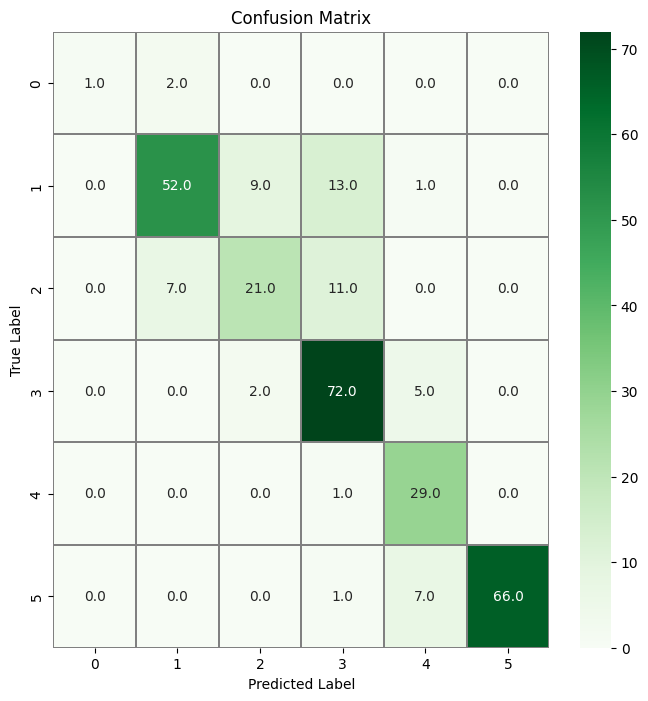

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
Y_pred_classes = y_predict_pm25
Y_true = y_test_pm25
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

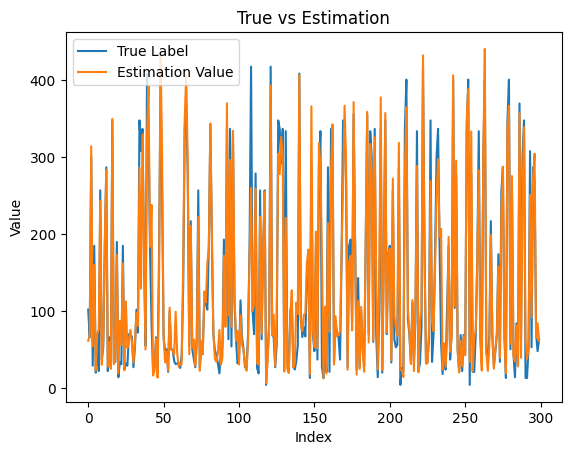

In [61]:
plt.plot(y_test, label='True Label')
plt.plot(y_predict, label='Estimation Value')

# set the x-axis label
plt.xlabel('Index')

# set the y-axis label
plt.ylabel('Value')

# set the plot title
plt.title('True vs Estimation')

# Adding a legend
plt.legend()

# display the plot
plt.show()